In [2]:
!pip install wfdb

In [3]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import os

In [5]:
print("Downloading MIT-BIH Arrhythmia Database...")
download_path = 'data/mit-bih-arrhythmia-database-1.0.0' 
wfdb.dl_database('mitdb', dl_dir=download_path)
print(f"Download complete! Files saved to: {download_path}")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=360, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [7]:
def label_group(label):
    """Group beat types into main categories"""
    if label in ['N', 'L', 'R', 'e', 'j']:
        return 'N'  # Normal
    elif label in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular
    elif label in ['V', 'E']:
        return 'V'  # Ventricular
    elif label in ['F']:
        return 'F'  # Fusion
    else:
        return 'Q'  # Other/Unknown

In [8]:
# Segmentation parameters
window_size = 250  # total length
pre, post = 100, 150  # samples before and after R-peak

all_X = []
all_y = []

# Get list of record files
record_files = [f.split('.')[0] for f in os.listdir(download_path) if f.endswith('.dat')]
print(f"\nFound {len(record_files)} records to process")

# Process each record
for rec_name in tqdm(sorted(record_files), desc="Processing records"):
    try:
        # Read record and annotations
        record = wfdb.rdrecord(os.path.join(download_path, rec_name))
        annotation = wfdb.rdann(os.path.join(download_path, rec_name), 'atr')

        # Get signal from first channel and apply filtering
        signal = record.p_signal[:, 0]
        filtered_signal = bandpass_filter(signal, fs=record.fs)

        ann_samples = annotation.sample
        ann_symbols = annotation.symbol

        # Extract segments around R-peaks
        segments = []
        labels = []

        for i, r_peak in enumerate(ann_samples):
            # Skip if segment would be incomplete
            if r_peak - pre < 0 or r_peak + post >= len(filtered_signal):
                continue

            beat_segment = filtered_signal[r_peak - pre:r_peak + post]
            segments.append(beat_segment)
            labels.append(label_group(ann_symbols[i]))

        if len(segments) > 0:
            segments = np.array(segments)
            labels = np.array(labels)

            # Normalize each segment (z-score normalization)
            X = (segments - np.mean(segments, axis=1, keepdims=True)) / \
                (np.std(segments, axis=1, keepdims=True) + 1e-6)

            all_X.append(X)
            all_y.append(labels)

    except Exception as e:
        print(f"\nError processing {rec_name}: {str(e)}")
        continue


Found 48 records to process


Processing records: 100%|██████████| 48/48 [00:09<00:00,  5.12it/s]


In [9]:
print("\nCombining data from all records...")
X_all = np.vstack(all_X)
y_all = np.hstack(all_y)

# Add channel dimension for CNN input
X_all = X_all[..., np.newaxis]

# Encode labels
le = LabelEncoder()
int_labels = le.fit_transform(y_all)

onehot = OneHotEncoder(sparse_output=False)
y_encoded = onehot.fit_transform(int_labels.reshape(-1, 1))

print(f"\nFinal dataset shape:")
print(f"X: {X_all.shape}")
print(f"y: {y_encoded.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y_all, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} samples ({count/len(y_all)*100:.2f}%)")



Combining data from all records...

Final dataset shape:
X: (112559, 250, 1)
y: (112559, 5)

Label distribution:
  F: 802 samples (0.71%)
  N: 90592 samples (80.48%)
  Q: 11149 samples (9.91%)
  S: 2781 samples (2.47%)
  V: 7235 samples (6.43%)


In [10]:
output_file = 'data/ecg_mitdb_processed.npz'
np.savez(output_file, X=X_all, y=y_encoded, label_names=le.classes_)
print(f"\nDataset saved to: {output_file}")


Dataset saved to: data/ecg_mitdb_processed.npz


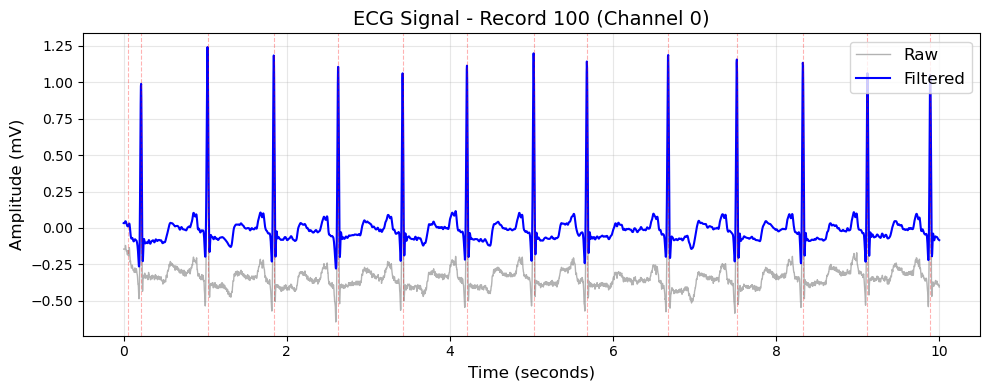

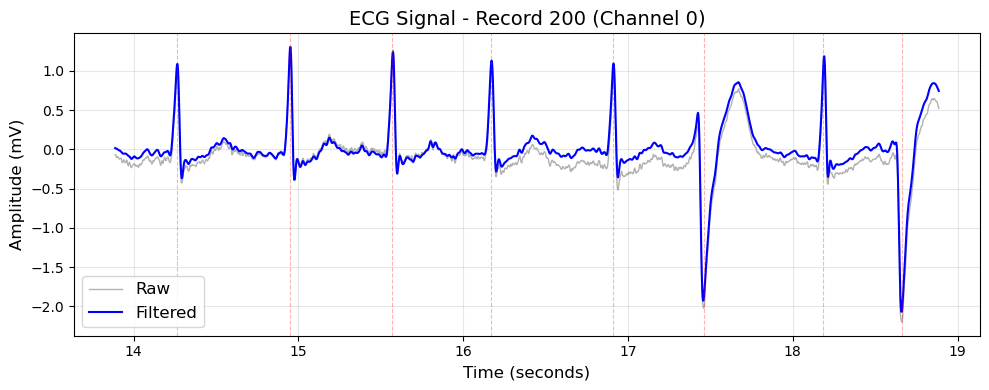

In [16]:
def visualize_signal(record_name, start=0, length=3000, channel=0):
    """
    Visualize raw and filtered ECG signal for any record

    Args:
        record_name: Name of the record (e.g., '100', '101')
        start: Starting sample index
        length: Number of samples to plot
        channel: Channel index (0 or 1 for MIT-BIH)
    """
    # Load record
    record = wfdb.rdrecord(os.path.join(download_path, str(record_name)))
    annotation = wfdb.rdann(os.path.join(download_path, str(record_name)), 'atr')

    # Extract signal
    signal_raw = record.p_signal[:, channel]
    signal_filtered = bandpass_filter(signal_raw, fs=record.fs)

    # Get R-peaks in the displayed range
    r_peaks = annotation.sample
    r_peaks_in_range = r_peaks[(r_peaks >= start) & (r_peaks < start + length)]

    # Plot
    plt.figure(figsize=(10, 4))
    time_axis = np.arange(start, start + length) / record.fs

    plt.plot(time_axis, signal_raw[start:start+length],
             label='Raw', alpha=0.6, linewidth=1, color='gray')
    plt.plot(time_axis, signal_filtered[start:start+length],
             label='Filtered', linewidth=1.5, color='blue')

    # Mark R-peaks
    for r_peak in r_peaks_in_range:
        plt.axvline(r_peak/record.fs, color='red', alpha=0.3, linestyle='--', linewidth=0.8)

    plt.legend(fontsize=12)
    plt.title(f'ECG Signal - Record {record_name} (Channel {channel})', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Amplitude (mV)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage examples:
visualize_signal('100', start=0, length=3600)  # First 10 seconds
visualize_signal('200', start=5000, length=1800)  # Different record

Sample beats visualization saved to: sample_beats.png


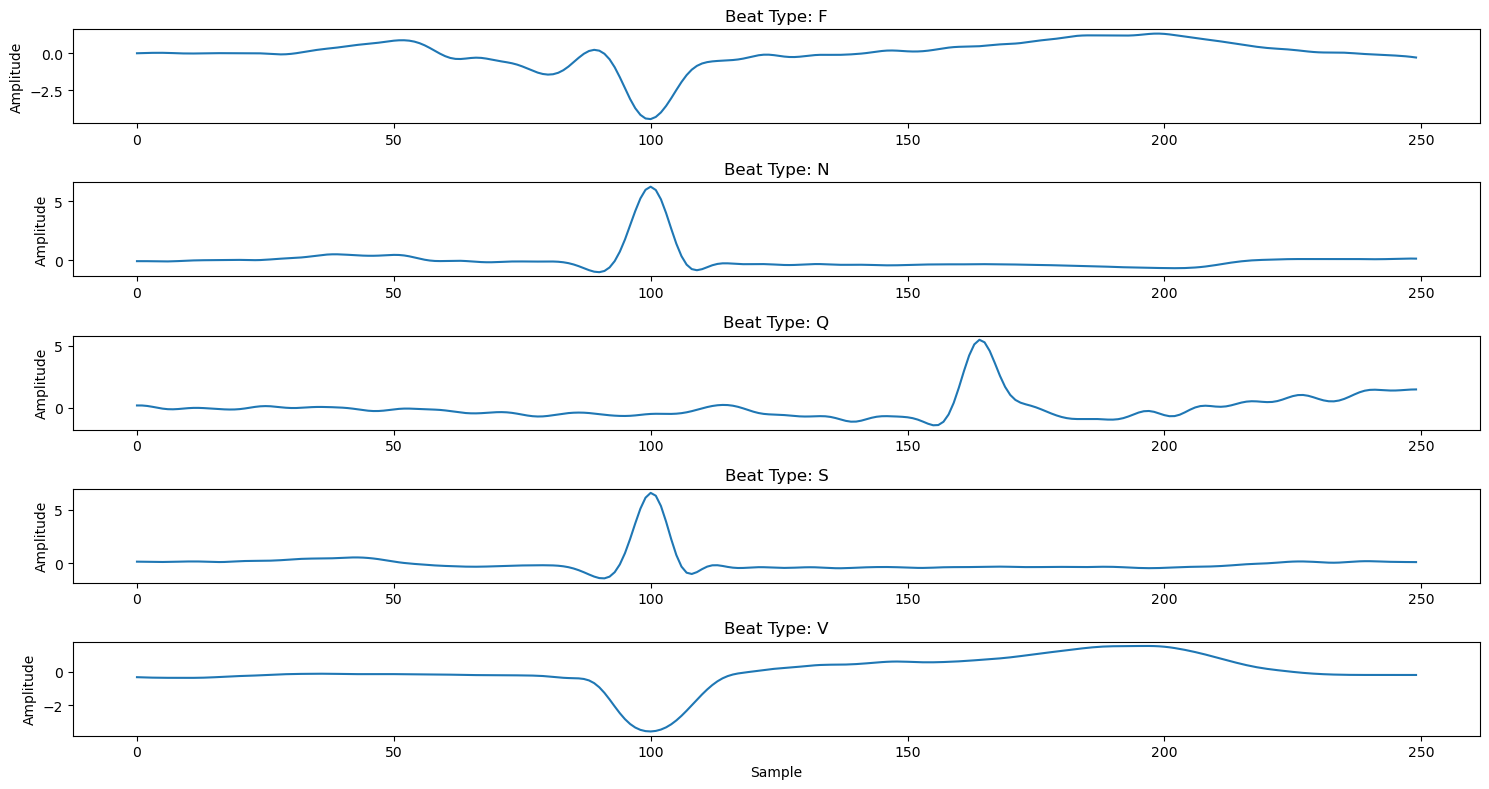

In [18]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(le.classes_):
    idx = np.where(y_all == label)[0][0]  # Get first occurrence
    plt.subplot(len(le.classes_), 1, i+1)
    plt.plot(X_all[idx, :, 0])
    plt.title(f'Beat Type: {label}')
    plt.ylabel('Amplitude')
    if i == len(le.classes_) - 1:
        plt.xlabel('Sample')
plt.tight_layout()
plt.savefig('sample_beats.png', dpi=150, bbox_inches='tight')
print("Sample beats visualization saved to: sample_beats.png")
plt.show()

In [19]:
X_all.shape

(112559, 250, 1)

In [20]:
y_all.shape

(112559,)

In [26]:
X_all[0], y_all[0]

(array([[-9.12955044e-02],
        [-9.03266420e-02],
        [-9.26049182e-02],
        [-9.93685477e-02],
        [-1.08265625e-01],
        [-1.14450798e-01],
        [-1.13342727e-01],
        [-1.03126330e-01],
        [-8.54990347e-02],
        [-6.45163530e-02],
        [-4.45594251e-02],
        [-2.86636115e-02],
        [-1.78327426e-02],
        [-1.12221086e-02],
        [-6.79028173e-03],
        [-2.19694207e-03],
        [ 4.10373760e-03],
        [ 1.18321915e-02],
        [ 1.85813205e-02],
        [ 2.08992005e-02],
        [ 1.65973161e-02],
        [ 6.96286465e-03],
        [-2.84472384e-03],
        [-5.89593919e-03],
        [ 3.02294989e-03],
        [ 2.47098433e-02],
        [ 5.52715048e-02],
        [ 8.83361577e-02],
        [ 1.18397342e-01],
        [ 1.43468297e-01],
        [ 1.65787445e-01],
        [ 1.90450400e-01],
        [ 2.22832701e-01],
        [ 2.65969165e-01],
        [ 3.18790225e-01],
        [ 3.75793413e-01],
        [ 4.28442166e-01],
 

## MODEL

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("Loading preprocessed data...")
data = np.load('ecg_mitdb_processed.npz')
X = data['X']
y = data['y']
label_names = data['label_names']

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Classes: {label_names}")


Loading preprocessed data...
Data shape: X=(112559, 250, 1), y=(112559, 5)
Classes: ['F' 'N' 'Q' 'S' 'V']


In [ ]:
print("\nSplitting data...")
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
)

# Second split: 80% train, 20% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Splitting data...
Train set: 72037 samples
Validation set: 18010 samples
Test set: 22512 samples


In [ ]:
print("\nBuilding LSTM model...")

def create_lstm_model(input_shape, num_classes):
    """
    Create LSTM model for ECG classification

    Args:
        input_shape: Shape of input (timesteps, features)
        num_classes: Number of output classes
    """
    model = models.Sequential([
        # First LSTM layer with return sequences
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # Second LSTM layer
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # Third LSTM layer (no return sequences - outputs single vector)
        layers.LSTM(32),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
input_shape = (X_train.shape[1], X_train.shape[2])  # (250, 1)
num_classes = y_train.shape[1]

model = create_lstm_model(input_shape, num_classes)



Building LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nModel Summary:")
model.summary()



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 250, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,637 (522.02 KB)

 Trainable params: 133,189 (520.27 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
try:
    plot_model(model, to_file='model_architecture.png',
               show_shapes=True, show_layer_names=True, dpi=150)
    print("Model architecture saved to: model_architecture.png")
except:
    print("Could not save model architecture diagram (graphviz may not be installed)")


Model architecture saved to: model_architecture.png


In [ ]:
# Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
checkpoint = callbacks.ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)



Training model...
Epoch 1/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7521 - loss: 0.7787 - precision: 0.8145 - recall: 0.6619
Epoch 1: val_accuracy improved from -inf to 0.85875, saving model to best_lstm_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7522 - loss: 0.7782 - precision: 0.8146 - recall: 0.6622 - val_accuracy: 0.8587 - val_loss: 0.5592 - val_precision: 0.8622 - val_recall: 0.8555 - learning_rate: 0.0010
Epoch 2/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8651 - loss: 0.4664 - precision: 0.8807 - recall: 0.8441
Epoch 2: val_accuracy improved from 0.85875 to 0.90283, saving model to best_lstm_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8651 - loss: 0.4663 - precision: 0.8808 - recall: 0.8442 - val_accuracy: 0.9028 - val_loss: 0.3576 - val_precision: 0.9238 - val_recall: 0.8763 - learning_rate: 0.0010
Epoch 3/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9033 - loss: 0.3609 - precis


Plotting training history...
Training history saved to: training_history.png


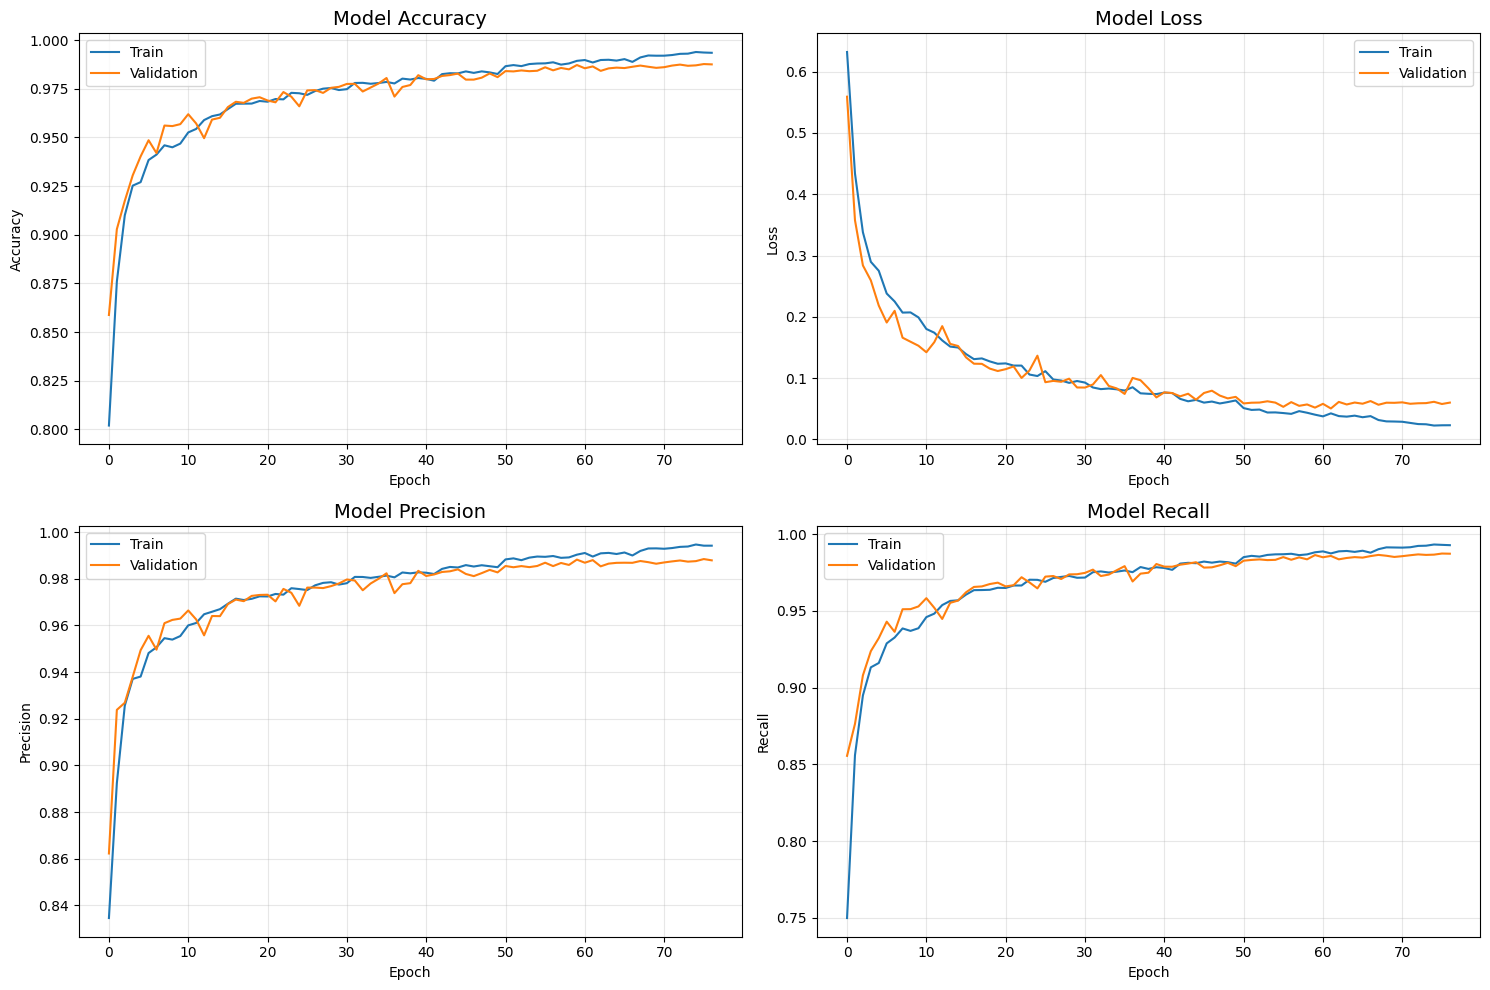

In [ ]:
print("\nPlotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Model Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Model Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print("Training history saved to: training_history.png")
plt.show()


In [ ]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("\nPer-Class Detailed Metrics:")
print("-" * 70)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, label in enumerate(label_names):
    print(f"{label:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")



EVALUATION ON TEST SET
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Test Loss: 0.0543
Test Accuracy: 0.9862
Test Precision: 0.9879
Test Recall: 0.9851

Classification Report:
              precision    recall  f1-score   support

           F     0.8794    0.7750    0.8239       160
           N     0.9909    0.9948    0.9928     18119
           Q     0.9784    0.9771    0.9778      2230
           S     0.9205    0.8741    0.8967       556
           V     0.9741    0.9599    0.9669      1447

    accuracy                         0.9862     22512
   macro avg     0.9487    0.9162    0.9316     22512
weighted avg     0.9860    0.9862    0.9861     22512


Per-Class Detailed Metrics:
----------------------------------------------------------------------
Class      Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
F          0.8794       0.7750       0.8239       160       
N          0.9909       0.9948       0.9928 


Generating confusion matrix...
Confusion matrix saved to: confusion_matrix.png


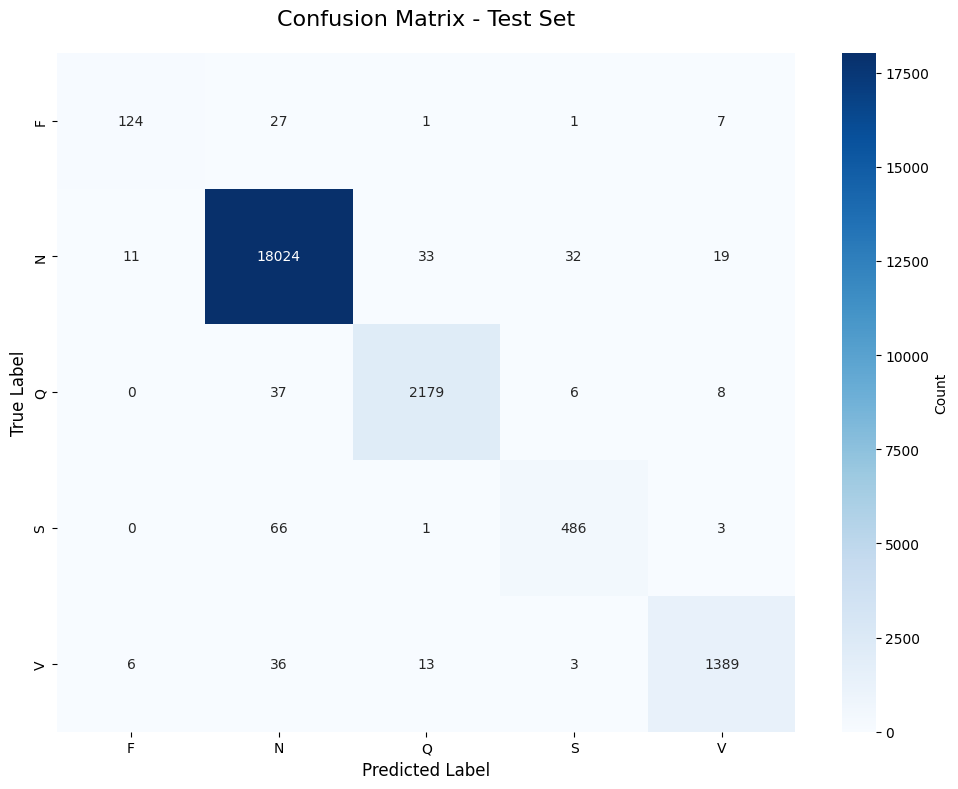

Normalized confusion matrix saved to: confusion_matrix_normalized.png


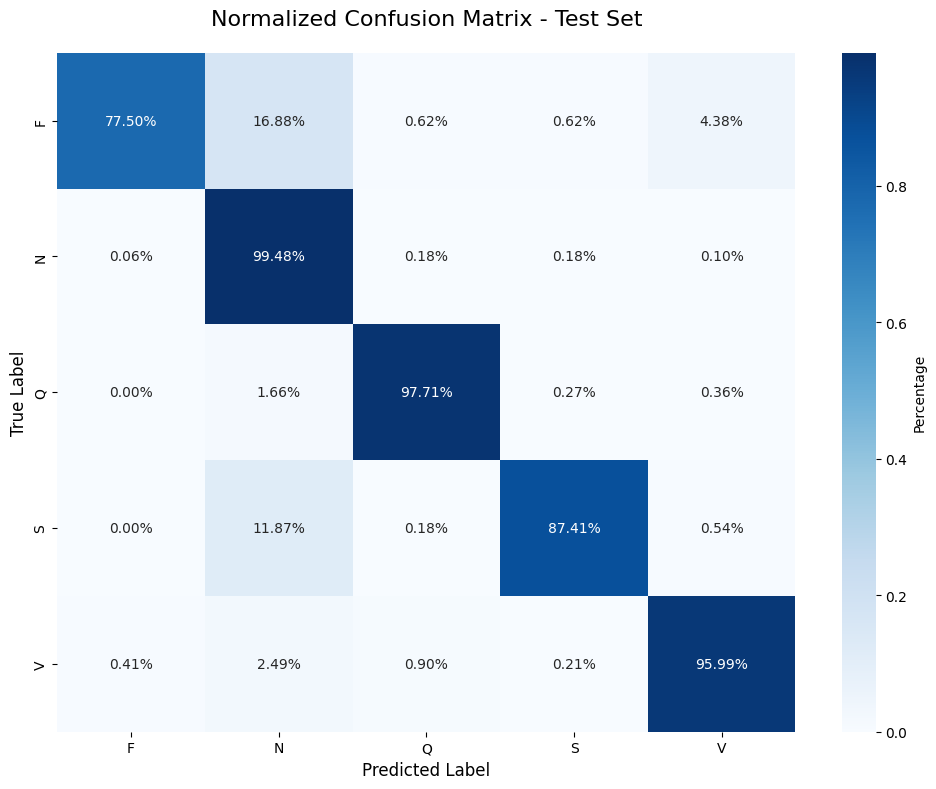

In [ ]:
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("Confusion matrix saved to: confusion_matrix.png")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
print("Normalized confusion matrix saved to: confusion_matrix_normalized.png")
plt.show()



Visualizing sample predictions...
Sample predictions saved to: sample_predictions.png


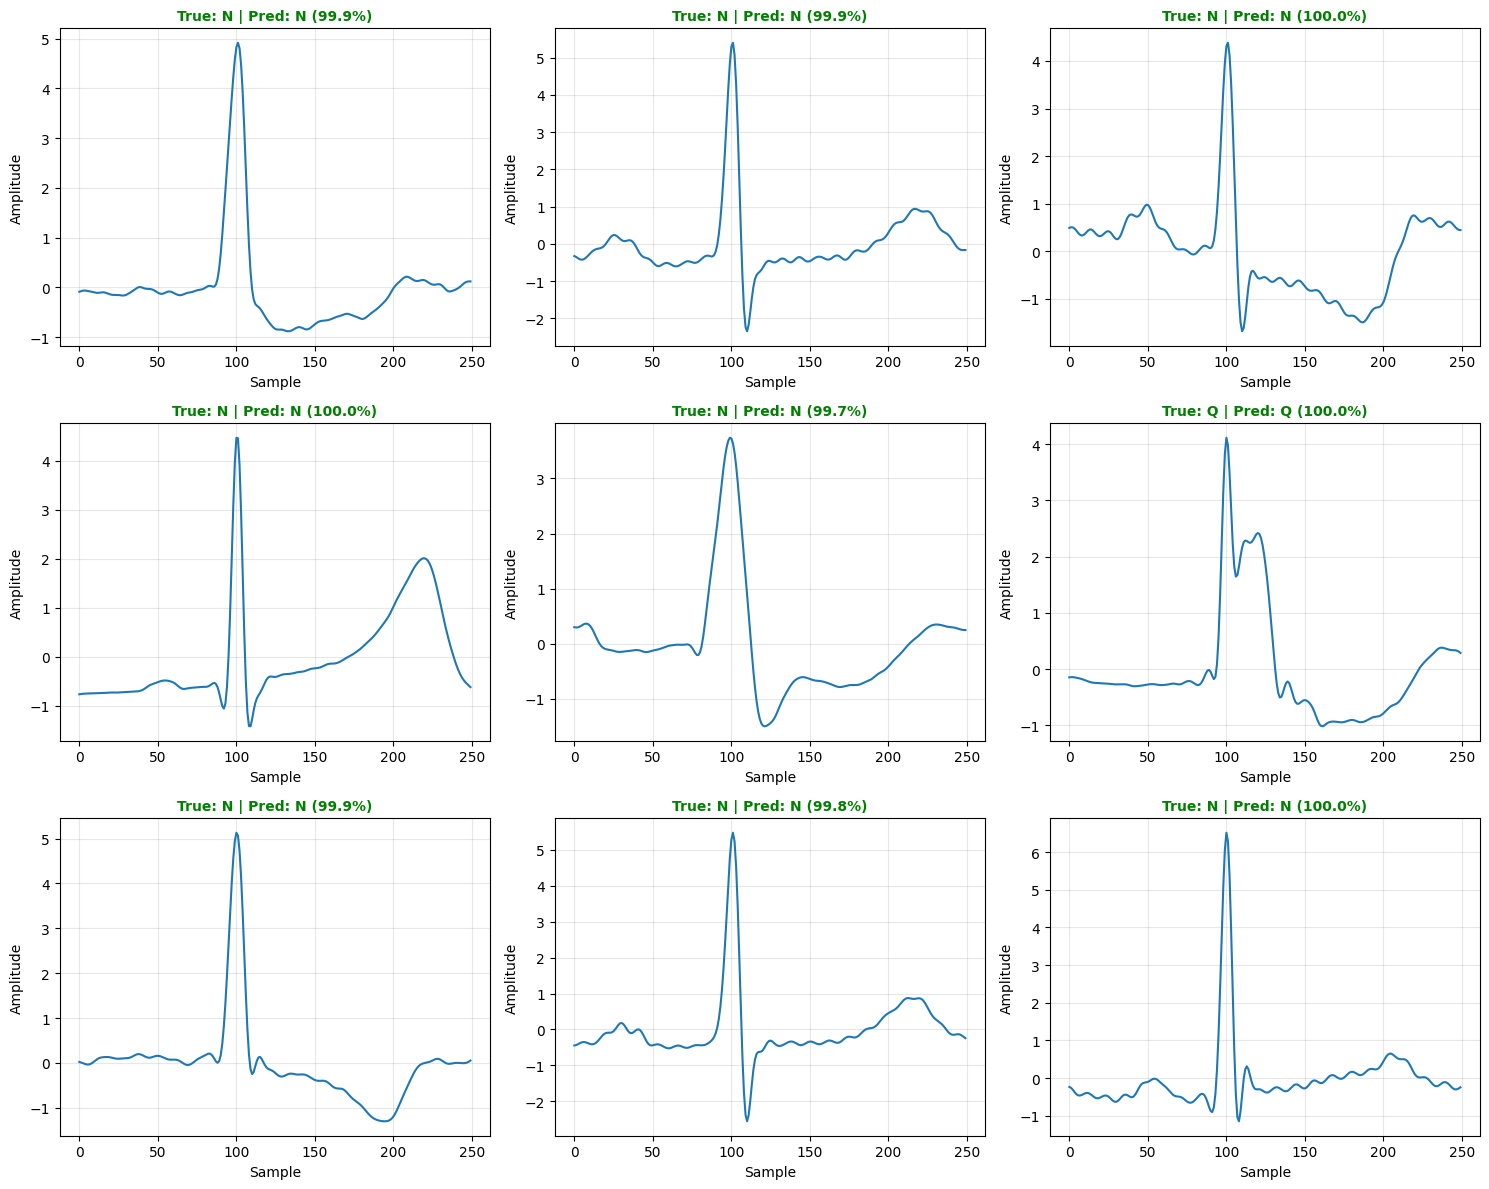

In [ ]:
print("\nVisualizing sample predictions...")
num_samples = min(9, len(X_test))
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100

    axes[i].plot(X_test[idx, :, 0])

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label} ({confidence:.1f}%)',
                     color=color, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
print("Sample predictions saved to: sample_predictions.png")
plt.show()